## Тестовое задание на позицию Аналитик медицинских данных  
## кандидата Кукеля Александра

        В качестве тестового задания предлагается 2 задачи, на выбор. По желанию, либо из творческого интереса можно сделать и обе, это конечно зачтется в карму, но решающим плюсом не будет, вполне достаточно одной, сделанной с душой. Задания открытые, не имеют одного правильного пути решения, можно абсолютно спокойно подойти к ним творчески. Очень круто будет показать пошаговый путь к решению, с графиками, маркдаунами и вообще качественно расписать ход мыслей. 
        
Первая задача: 
    В ходе эксперимента с помощью нашего миографа была сделана запись электрофизиологической активности с поверхности левой больщой грудной мышцы в покое, с небольшим мышечным напряжением и максимальным усилием, а так же при беге на месте. В результате, на записи в начале присутствуют чистые комплексы QRS ЭКГ,  после они частично или полностью перекрываются двумя всплесками ЕМГ, а в конце комплексы QRS загрязнены двигательными артефактами. Собственно, необходимо:
    1: получить массив R-R интервалов, показать невалидные интервалы, в которых комплексы QRS обнаружить не представляется возможным.
    2: написать(или концептуально описать) алгоритм, который позволит определять в каком месте на сигнале видны QRS комплексы, в каком месте видна ЕМГ активность, и где можно выделить двигательный артефакт. 
   
    Частота дискретизации миографа - 1000 значений в секунду. 

Вторая задача:
    

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.signal as signal
import math

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

from IPython.display import clear_output
from ipywidgets import widgets


In [3]:
data = pd.read_csv ("ECG&EMG_RECORD.csv", index_col= "Unnamed: 0")

In [4]:
def Plots (df, numb = 10):
    '''
    Breaks the dataframe (df) into (numb) pieces and builds a graph for each
    '''
    span = math.ceil(df.size/numb)
    for i in range (numb):
        sns.lineplot(data = df.iloc[i*span:(i+1)*span])
        plt.figure()

In [5]:
def PlotsPeaks (df, peaks, numb = 10):
    '''
    Breaks the dataframe (df) into (numb) pieces and builds a graph for each with peaks
    '''
    span = math.ceil(df.size/numb)
    for i in range (numb):       
        x = df.iloc[i*span:(i+1)*span]["Channel 1"]
        peaks_range = x[x.index.isin(df.iloc[peaks].index)].index
        sns.lineplot(data = x, zorder = 1)
        sns.scatterplot (x = x.loc[peaks_range].index, y = x.loc[peaks_range].values, color = 'r', marker = 'v', \
                         s = 50, zorder = 2)
        plt.figure()

In [6]:
def Plot_Invalid_Zone (df, peaks, span):
    """
    Plots a graph and highlights uncovered areas (peaks+-span)
    """
    x0 = np.append([0], [peaks+span])
    x1 = np.append([peaks-span], df.index.max())

    ax = sns.lineplot(data = df)
    
    for i in range (len(x0)):   
        if (x0[i]<x1[i]):
            plt.axvline(x=x0[i],color='hotpink')
            plt.axvline(x=x1[i],color='hotpink')   
            ax.axvspan(x0[i], x1[i], color='hotpink', alpha=0.5)
    
    plt.show()

In [7]:
def Plot_Zone (df, peaks, span, color):
    """
    Plots a graph and highlights the corresponding zones (peaks+span)
    """
    x0 = [peaks[0]]
    x1 = []
    
    temp = peaks[0]
    
    for i in peaks:
        if (temp+span<i):
            x1.append(temp+span)
            x0.append(i)
        temp = i
    
    if temp+span>df.index.max():
        x1.append(df.index.max())
    else:
        x1.append(temp+span)

    ax = sns.lineplot(data = df)
    
    for i in range (len(x0)):   
            plt.axvline(x=x0[i],color=color)
            plt.axvline(x=x1[i],color=color)   
            ax.axvspan(x0[i], x1[i], color=color, alpha=0.5)
    
    plt.show()

In [8]:
def Predict_Zone (df, left, right, params):
    """
    Predict a zone using interval (left-right) and 
    params (dict with keys "std", "25%", "75%", pair(minmax_ratio_1) and pair(minmax_ratio_2))
    """
    d = {0: "Noise", 1:"QRS_zone", 2:"EMG_zone", 3:"Artifact_zone"}
    df = df.loc[left:right]
    span_wind = right - left
    q = df["Channel 1"].describe()
    q["minmax_ratio"] = abs(q["max"]/q["min"])

    if q["std"] > params["std"]: 
        if q["25%"] > params["25%"] and q["75%"] < params["75%"]:
            if q["minmax_ratio"] < params["minmax_ratio_1"][0] or q["minmax_ratio"] > params["minmax_ratio_1"][1]:
                return d[3]
            else:
                 return d[1]
        elif q["minmax_ratio"] < params["minmax_ratio_2"][0] or q["minmax_ratio"] > params["minmax_ratio_2"][1]:
             return d[3]
        else:
             return d[2]
    else:
         return d[0]

In [9]:
def Testing_zone_selection (numb_iter, span = 5000, auto = "Yes", print_all = "Yes"):
    """
    Testing the Zone search algorithm
    """
    pos, neg, tot = 0, 0, numb_iter
    for i in range(numb_iter):
        if (auto == "Yes"):
            left = np.random.randint(data["Channel 1"].max())
            right = np.random.randint(left, min(data["Channel 1"].max(), left+span))
        else:
            left = int(input())
            right = int(input())
        Plot_Zone (data, [left], right-left, colors[Predict_Zone (data, left, right, params)])
        print (Predict_Zone (data, left, right, params))
        print ("No(0), Yes(1), Bad Interval(2)")
        choice = int(input())
        if (choice == 2):
            tot -= 1
        elif (choice == 0 ):
            neg += 1
        else:
            pos +=1
        if (print_all is not "Yes"):
            clear_output()
    return pos/tot*100

In [10]:
def Smoothing (df, smoothing):
    '''
    Smoothing by replacing n points (smoothing) with one averaged point
    '''
    temp = []
    ind = []
    for i in range (0, df.size-smoothing, smoothing):
        temp.append(df["Channel 1"].iloc[i:i+smoothing].sum()/smoothing)
        ind.append(i)
    return pd.DataFrame(index = ind, data = temp, columns = ["Channel 1"])

In [11]:
def SimpleSmoothing (df, smoothing):  
    '''
    Simple smoothing (option)
    All points saved
    '''
    temp = []
    for i in range (df.size):
        if (i+smoothing < df.size):
            temp.append(df["Channel 1"].iloc[i:i+smoothing].sum()/smoothing)
        else:
            temp.append(df["Channel 1"].iloc[i:].sum()/(df.size-i))
    return pd.DataFrame(data = temp, columns = ["Channel 1"])

In [12]:
def ExpSmoothing(series, alpha):
    """
    Exponential smoothing (option)
    All points saved
    """
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [13]:
def F1 (actual, pred, size, span = 20):
    """
    precision, recall and F1 calculation
    """
    tp = 0
    fn = 0
    fp = 0
    
    for i in pred:
        for j in range (len(actual)):
            if i in range(actual[j]-span, actual[j]+span):
                act = np.delete(actual, j)
                tp += 1
                break
        else:
            fp += 1
            
    fn = actual.size - tp
    
    if (tp == 0):
        return 0, 0, 0
    
    prec = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2*prec*recall/(prec+recall)
    return prec, recall, f1

##### Ход решения:
    1)сглаживание исходных данных для поиска "скрытых" комплекcов QRS
        а)используя алгоритм простого сглаживания (с уменьшение количества точек)
        б)используя алгоритм простого сглаживания (с сохранением количествава точек)
        в)используя алгоритм экспоненциального сглаживания
    2)поиск комплекcов QRS
        а)используя find_peaks_cwt
        б)используя find_peaks
    3)поиск невалидные интервалы, в которых комплексы QRS обнаружить не удалось
    4)разработка алгоритма классификации зон:
        а)анализ данных и ручной подбор характеристик для классификации и их значений
        б)опитимазация характеристик для классификации и их значений с помощью бинарного дерева решений
    5)тестирование алгоритма классификации зон:
        а)использую автоматически генерируемы интервалы
        б)исполузую интервалы, задаваемые вручную
    6)анализ заданной зоны

# Data smoothing

In [14]:
numb = 1 #Change the numb (fromm 1 to 20) for deep analysis

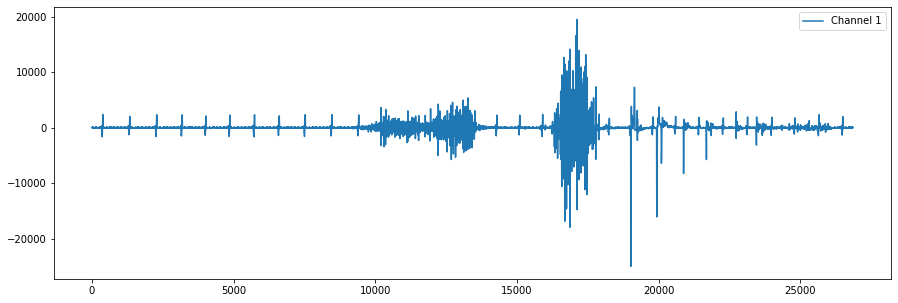

<Figure size 1080x360 with 0 Axes>

In [15]:
Plots (data, numb) #Original data

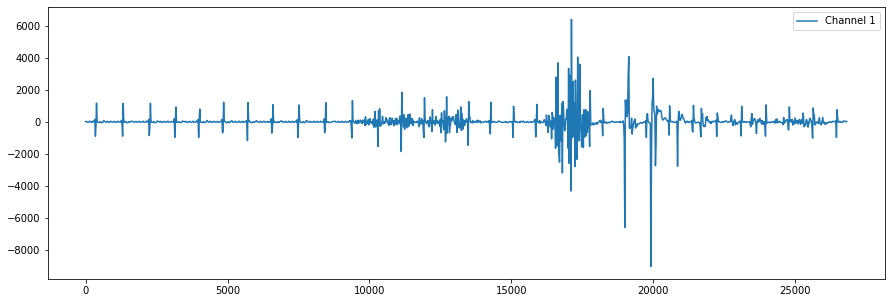

<Figure size 1080x360 with 0 Axes>

In [16]:
Plots (Smoothing (data, 20), 1)

#Plots (Smoothing (Smoothing (data, 20), 1), numb)
#Plots (Smoothing (data, 30), 1)

### Smoothing using other function

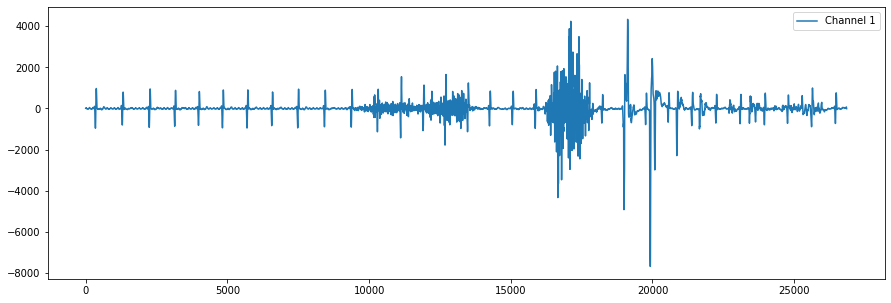

<Figure size 1080x360 with 0 Axes>

In [17]:
Plots (SimpleSmoothing (data, 30), numb = numb)

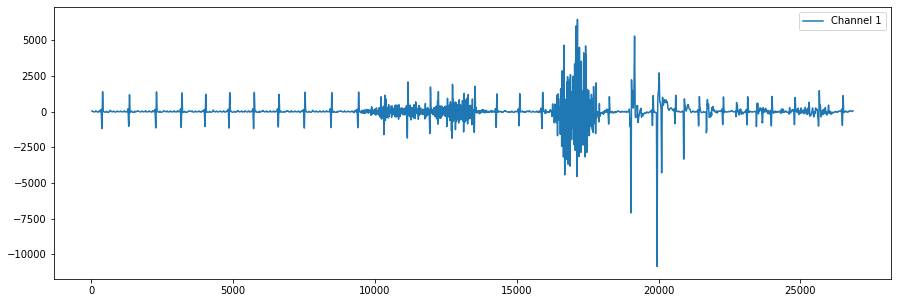

<Figure size 1080x360 with 0 Axes>

In [18]:
Plots(data.rolling(window = 20).mean(), numb = numb)

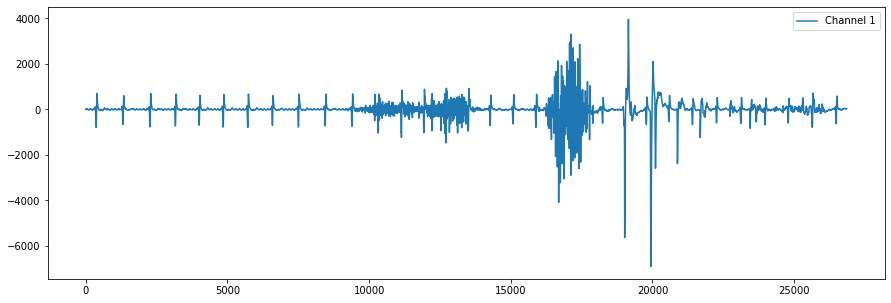

<Figure size 1080x360 with 0 Axes>

In [19]:
Plots(pd.DataFrame(ExpSmoothing(data["Channel 1"], 0.05), columns = ["Channel 1"]), numb = numb)

In [20]:
#hardcode correnct peak's values for future analysis & F1 calculation

peaks_act = np.array([380, 1320, 2280, 3180, 4020, 4860, 5720, 6600, 7520, 8460, 9400, 10360, 11140, 11940, 12720, \
                      13500, 14280, 15080, 15900, 16680, 17460, 18240, 19800, 20580, 21420, 22260, 23120, 23980, \
                      24800, 25640, 26480])

# Peak's search

In [21]:
data_cln = Smoothing(data, 20)
# data_cln = SimpleSmoothing(data, 30)
# ...

### find_peaks_cwt

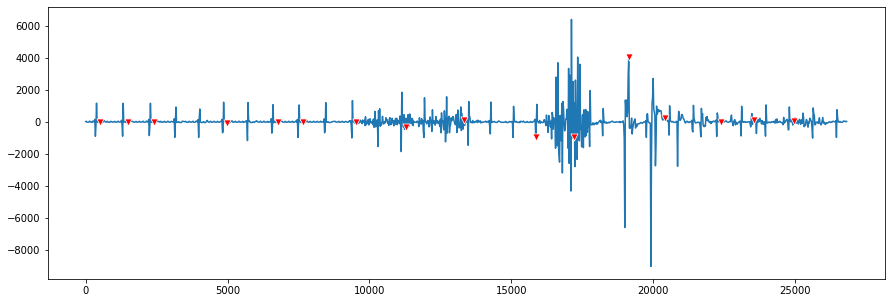

<Figure size 1080x360 with 0 Axes>

In [22]:
#bad optimized (skip this part)
peaks = signal.find_peaks_cwt(data_cln["Channel 1"], np.arange(20,50), noise_perc = 100)
PlotsPeaks (data_cln, peaks, numb = 1)

In [23]:
data_cln.iloc[peaks].index

Int64Index([  520,  1500,  2420,  4980,  6760,  7660,  9540, 11300, 13320,
            15860, 17200, 19140, 20400, 22400, 23540, 24960],
           dtype='int64')

In [24]:
R_R_int = np.diff(data_cln.iloc[peaks].index.to_numpy())
R_R_int

array([ 980,  920, 2560, 1780,  900, 1880, 1760, 2020, 2540, 1340, 1940,
       1260, 2000, 1140, 1420], dtype=int64)

In [25]:
F1(peaks_act, data_cln.iloc[peaks].index, data.size, 200)

(0.8125, 0.41935483870967744, 0.5531914893617021)

### find_peaks

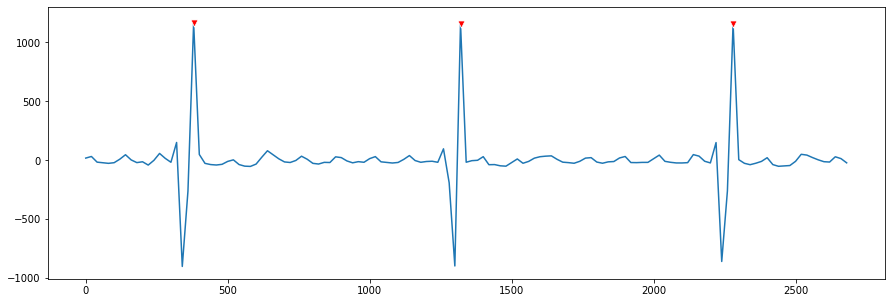

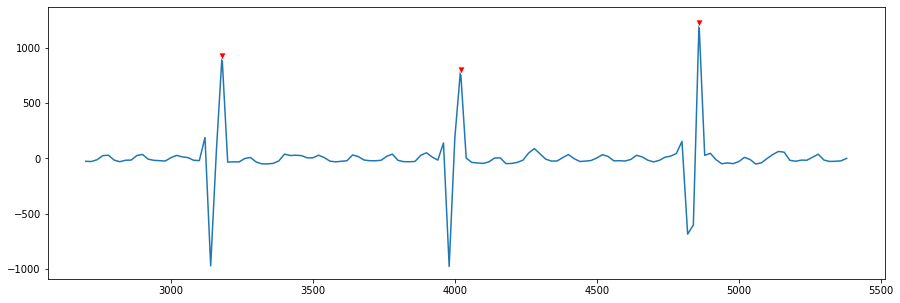

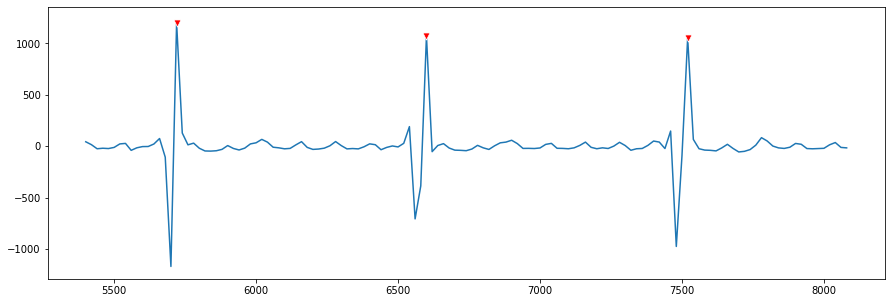

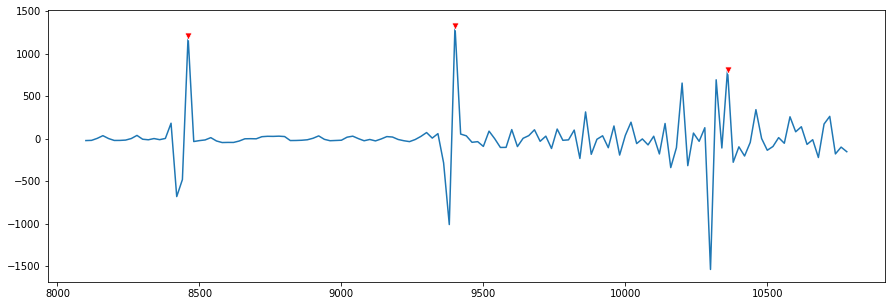

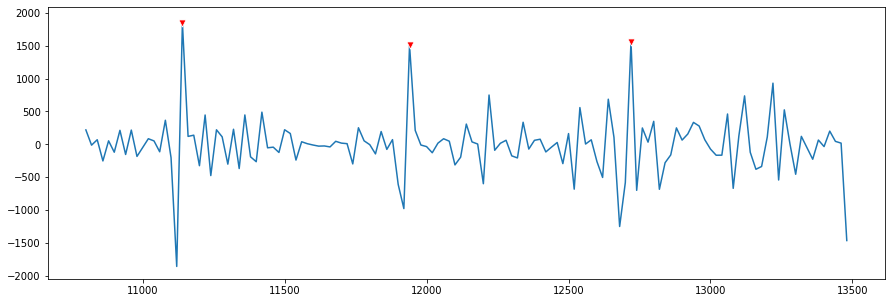

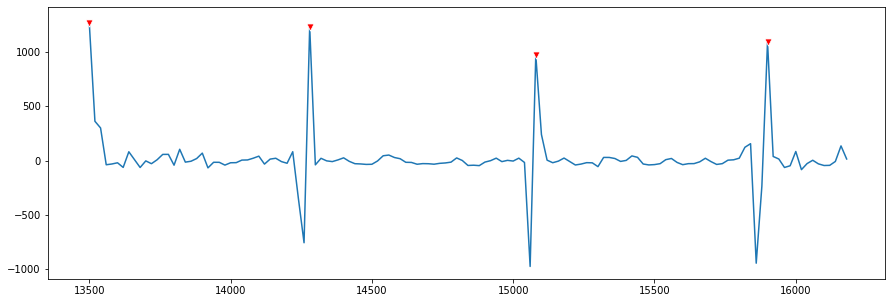

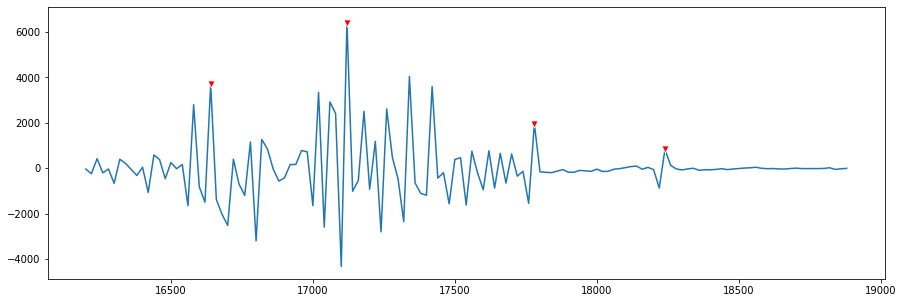

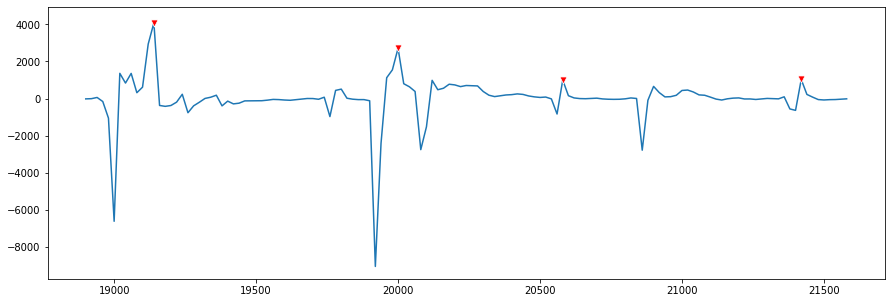

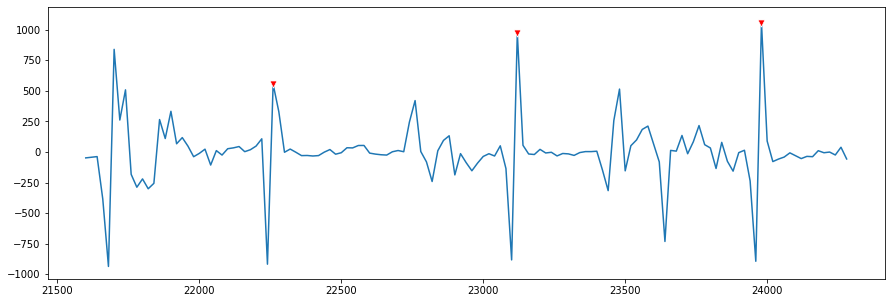

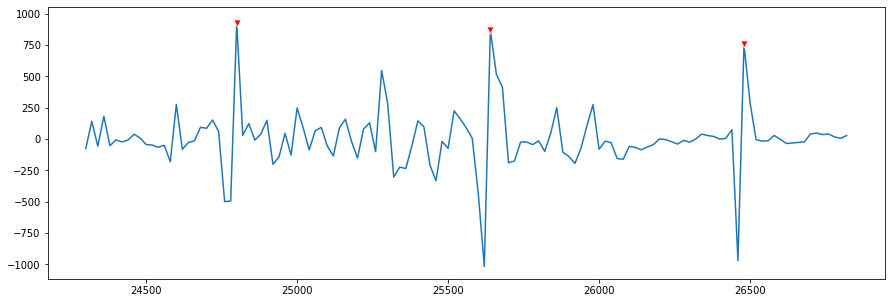

<Figure size 1080x360 with 0 Axes>

In [26]:
peaks, prop = signal.find_peaks(data_cln["Channel 1"], height = 500, distance = 20)
PlotsPeaks (data_cln, peaks)

In [27]:
F1(peaks_act, data_cln.iloc[peaks].index, data.size, 100)

(0.8787878787878788, 0.9354838709677419, 0.90625)

In [28]:
data_cln.iloc[peaks].index

Int64Index([  380,  1320,  2280,  3180,  4020,  4860,  5720,  6600,  7520,
             8460,  9400, 10360, 11140, 11940, 12720, 13500, 14280, 15080,
            15900, 16640, 17120, 17780, 18240, 19140, 20000, 20580, 21420,
            22260, 23120, 23980, 24800, 25640, 26480],
           dtype='int64')

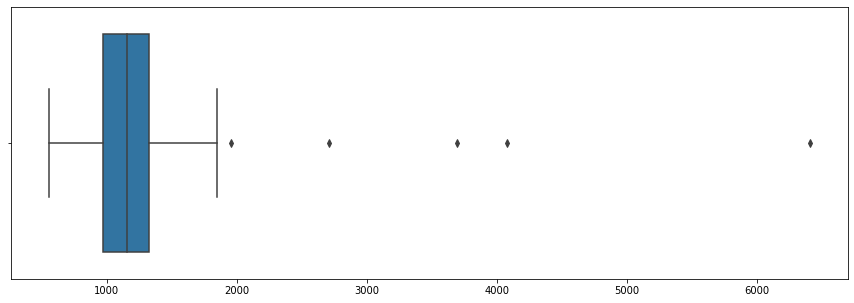

In [29]:
sns.boxplot(x = prop['peak_heights'])

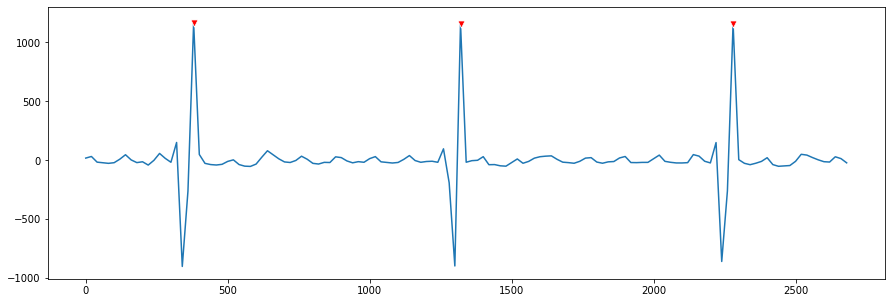

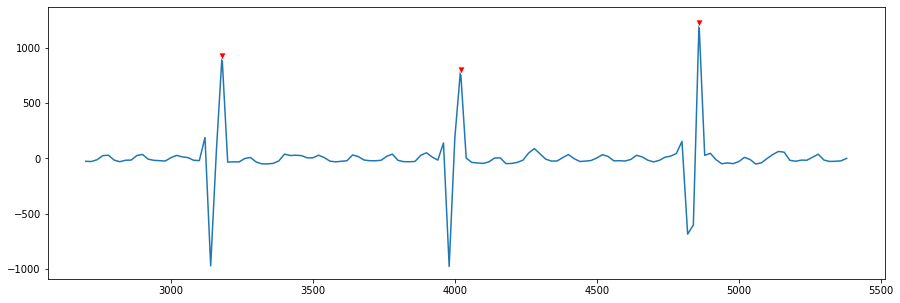

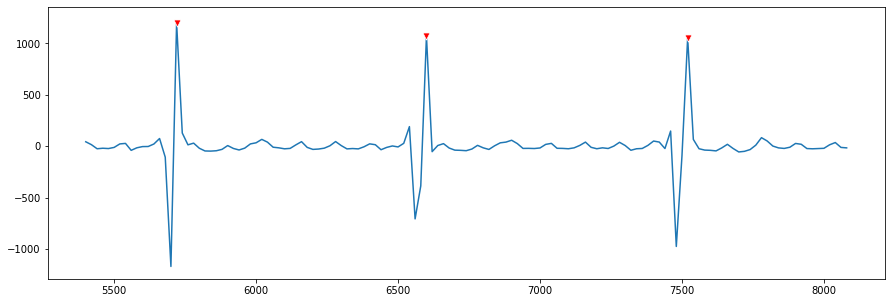

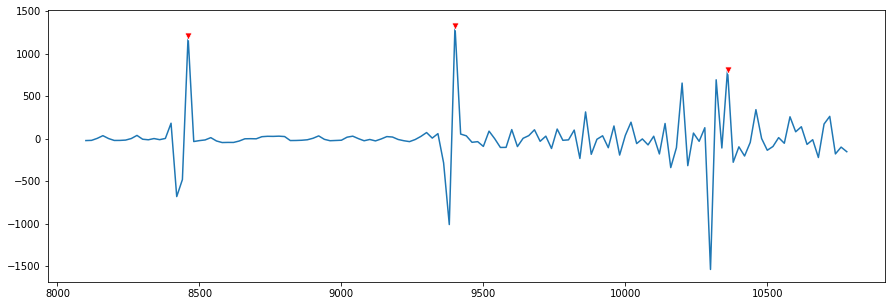

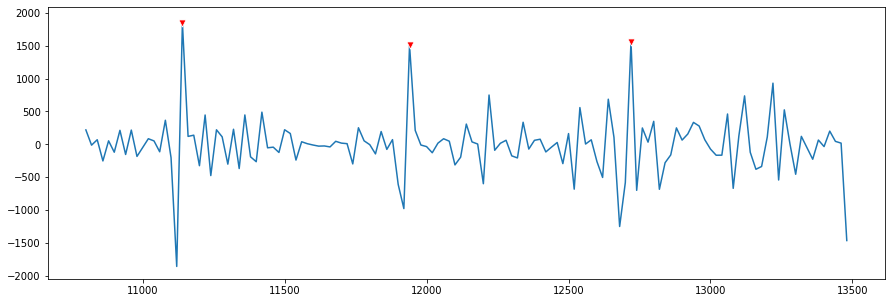

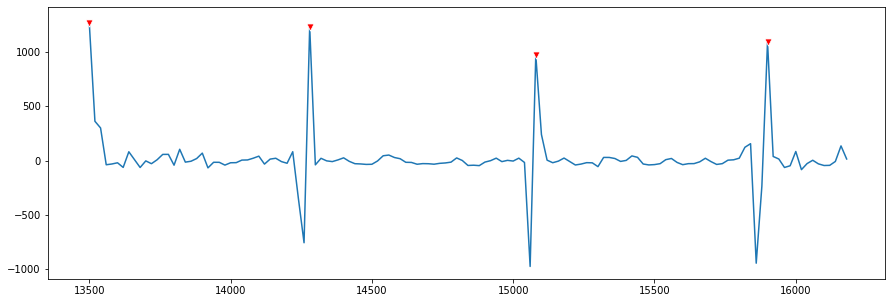

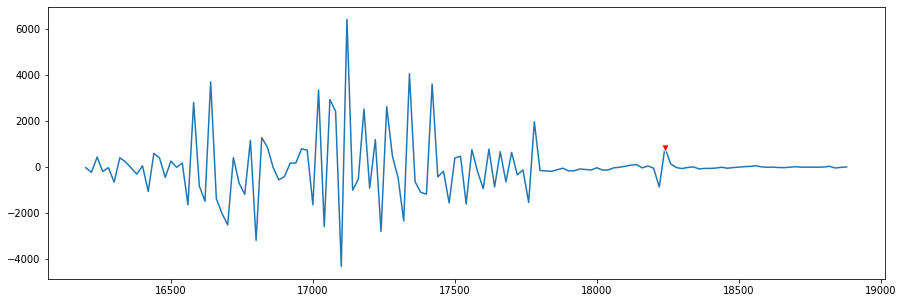

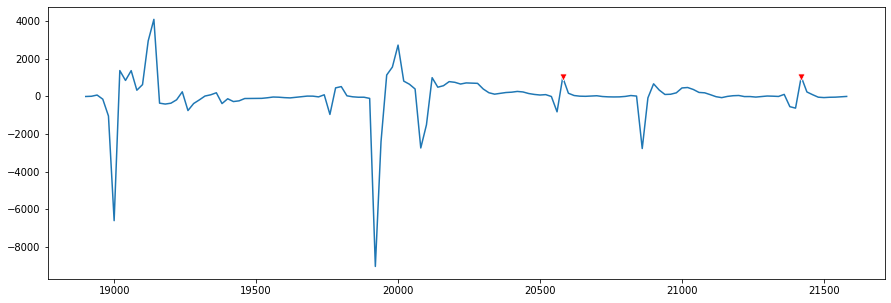

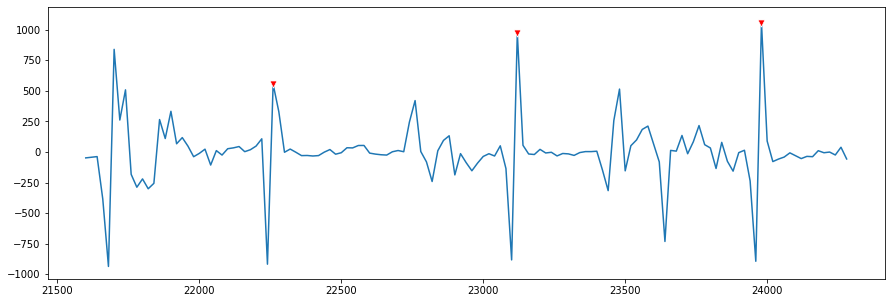

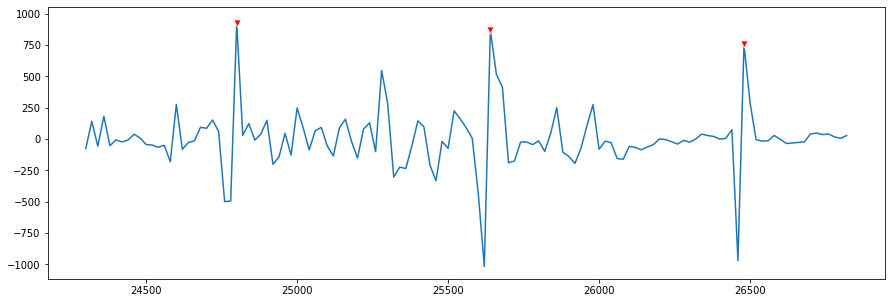

<Figure size 1080x360 with 0 Axes>

In [30]:
#exclude outliers by height
upper = np.quantile(prop['peak_heights'], 0.75)\
        +(np.quantile(prop['peak_heights'], 0.75)-np.quantile(prop['peak_heights'], 0.25))*1.5
lower = np.quantile(prop['peak_heights'], 0.25)\
        -(np.quantile(prop['peak_heights'], 0.75)-np.quantile(prop['peak_heights'], 0.25))*1.5

updated_peaks = peaks[(prop['peak_heights']<=upper) & (prop['peak_heights']>=lower)]
PlotsPeaks (data_cln, updated_peaks)

# Answers to the first part

In [31]:
F1(peaks_act, data_cln.iloc[updated_peaks].index, data.size, 100)

(1.0, 0.9032258064516129, 0.9491525423728813)

In [32]:
data_cln.iloc[updated_peaks].index

Int64Index([  380,  1320,  2280,  3180,  4020,  4860,  5720,  6600,  7520,
             8460,  9400, 10360, 11140, 11940, 12720, 13500, 14280, 15080,
            15900, 18240, 20580, 21420, 22260, 23120, 23980, 24800, 25640,
            26480],
           dtype='int64')

In [33]:
R_R_int = np.diff(data_cln.iloc[updated_peaks].index.to_numpy())
R_R_int

array([ 940,  960,  900,  840,  840,  860,  880,  920,  940,  940,  960,
        780,  800,  780,  780,  780,  800,  820, 2340, 2340,  840,  840,
        860,  860,  820,  840,  840], dtype=int64)

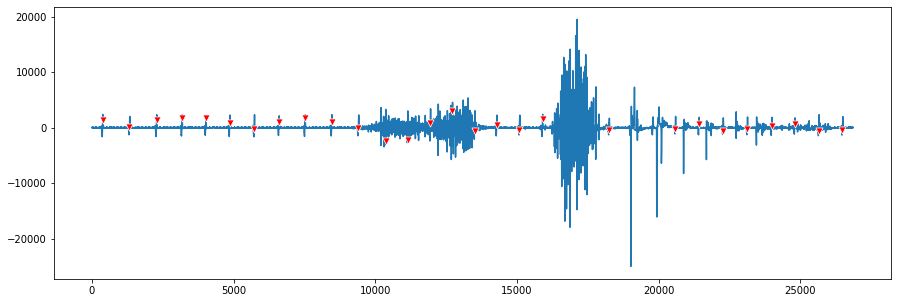

<Figure size 1080x360 with 0 Axes>

In [34]:
PlotsPeaks (data, data_cln.iloc[updated_peaks].index, numb = 1)

# Invalid zone's search

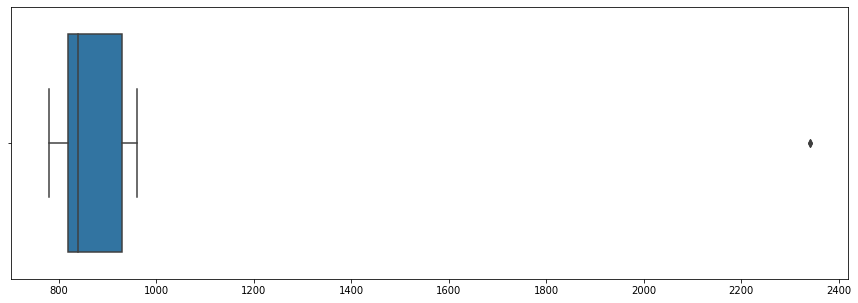

In [35]:
sns.boxplot (x = R_R_int)

In [36]:
#exclude outliers by interval
upper = np.quantile(R_R_int, 0.75)+(np.quantile(R_R_int, 0.75)-np.quantile(R_R_int, 0.25))*1.5
lower = np.quantile(R_R_int, 0.25)-(np.quantile(R_R_int, 0.75)-np.quantile(R_R_int, 0.25))*1.5

updated_R_R_int = R_R_int[(R_R_int<=upper) & (R_R_int>=lower)]

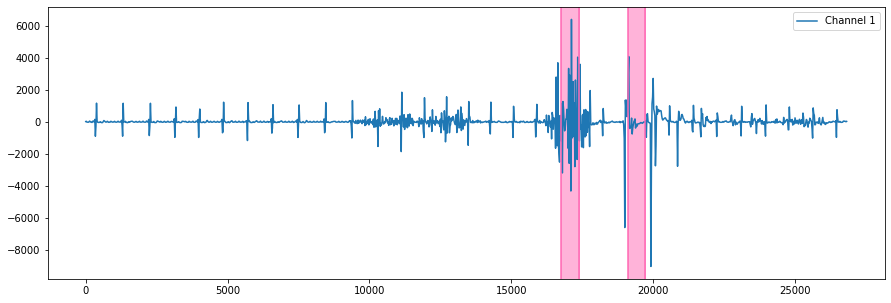

In [37]:
Plot_Invalid_Zone (data_cln, data_cln.iloc[updated_peaks].index.to_numpy(), np.average(updated_R_R_int))

## Optimization (for previous part)

In [38]:
# works for a long time (skip this part)
1/0

tot_f1 = 0

for s in range(1, 50, 2):
    for h in range (100, 1000, 300):
        for d in range (5, 100, 10):
            data_cln = Smoothing(data, s)
            peaks, _ = signal.find_peaks(data_cln["Channel 1"], height = h, distance = d)
            f1 = F1(peaks_act, data_cln.iloc[peaks].index, data.size, 100)
            if (f1[2]>0.85):
                print (s, h, d, f1)
            if (f1[2]>tot_f1):
                tot_f1 = f1[2]

ZeroDivisionError: division by zero

# Zone's search

In [40]:
span_wind = 300
q = data["Channel 1"].groupby(data.index//span_wind).describe()
q["15%"] = data["Channel 1"].groupby(data.index//span_wind).quantile(0.15)
q["85%"] = data["Channel 1"].groupby(data.index//span_wind).quantile(0.85)
q.index*=span_wind
q["minmax_ratio"] = abs(q["max"]/q["min"])
q = q.drop(["count", "50%", "min", "max"], axis = 1)

In [41]:
q

,mean,std,25%,75%,15%,85%,minmax_ratio
0,2.103333,41.892113,-26.0,32.00,-35.00,49.15,1.397959
300,-5.966667,520.802698,-62.0,31.50,-76.15,70.15,1.455882
600,5.406667,47.212973,-30.0,34.00,-41.00,55.30,1.774194
900,-1.926667,40.031358,-29.0,25.25,-38.00,36.00,1.623377
1200,-1.526667,446.405648,-53.0,28.00,-72.15,81.15,1.600784
...,...,...,...,...,...,...,...
25500,20.126667,560.733338,-257.0,180.50,-404.80,331.95,1.622917
25800,-25.970000,238.611975,-170.0,101.00,-225.00,215.20,0.924411
26100,-21.723333,48.685945,-58.0,13.00,-72.15,30.00,0.916084
26400,2.453333,423.091451,-44.0,15.50,-65.15,73.45,1.498868


In [42]:
QRS_zone = []
EMG_zone = []
artifact_zone = []

act_zone = []

for i in q.index:
    if q.loc[i]["std"] > 100: 
        if q.loc[i]["15%"] > -300 and q.loc[i]["85%"] < 300:
            QRS_zone.append(i)
        elif q.loc[i]["minmax_ratio"] > 2.5 or q.loc[i]["minmax_ratio"] < 0.4:
            artifact_zone.append(i)
        else:
            EMG_zone.append(i)

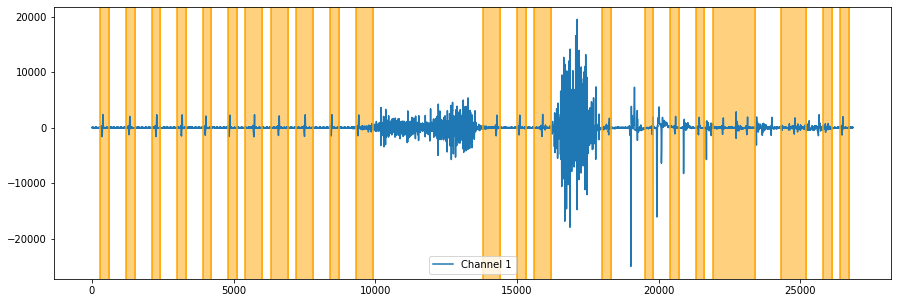

In [43]:
Plot_Zone (data, QRS_zone, span_wind, "orange")

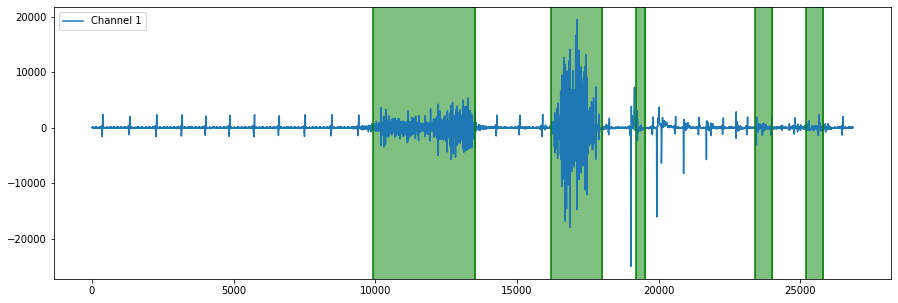

In [44]:
Plot_Zone (data, EMG_zone, span_wind, "g")

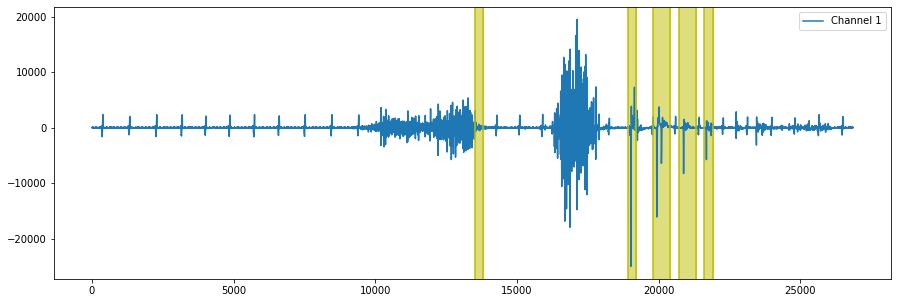

In [45]:
Plot_Zone (data, artifact_zone, span_wind, "y")

In [46]:
# hardcode correnct zone's values for future testing
act_zone = [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 2, 2, 2, 2, 2, 2, \
            2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 0, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1, 0, 0, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3,\
            1, 1, 3, 1, 0, 1, 1, 1, 3, 1, 1, 0, 1, 0]
q["zone"] = act_zone

## Optimization with Tree

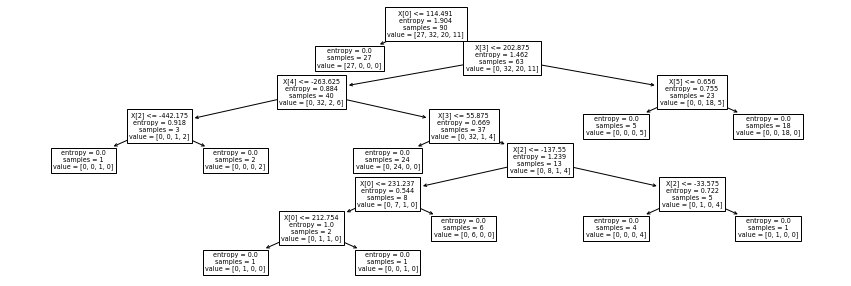

In [47]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion="entropy")
X = q[["std", "85%", "15%", "75%", "25%", "minmax_ratio", "mean"]]
y = q ["zone"]
clf.fit (X, y)
tree.plot_tree (clf);

In [63]:
QRS_zone = []
EMG_zone = []
artifact_zone = []

for i in q.index:
    if q.loc[i]["std"] > 115: 
        if q.loc[i]["25%"] > -264 and q.loc[i]["75%"] < 203:
            if q.loc[i]["minmax_ratio"] < 0.2 or q.loc[i]["minmax_ratio"] > 5:
                artifact_zone.append(i)
            else:
                QRS_zone.append(i)
        elif q.loc[i]["minmax_ratio"] < 0.656 or q.loc[i]["minmax_ratio"] > 1.5:
            artifact_zone.append(i)
        else:
            EMG_zone.append(i)

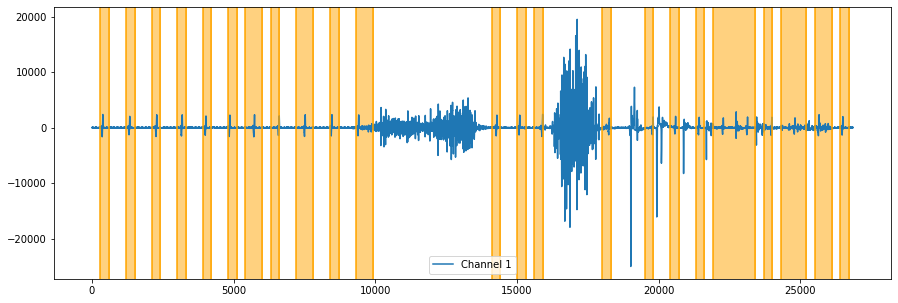

In [49]:
Plot_Zone (data, QRS_zone, span_wind, "orange")

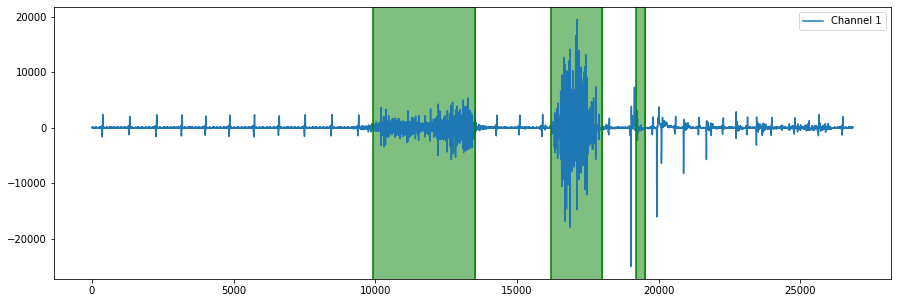

In [50]:
Plot_Zone (data, EMG_zone, span_wind, "g")

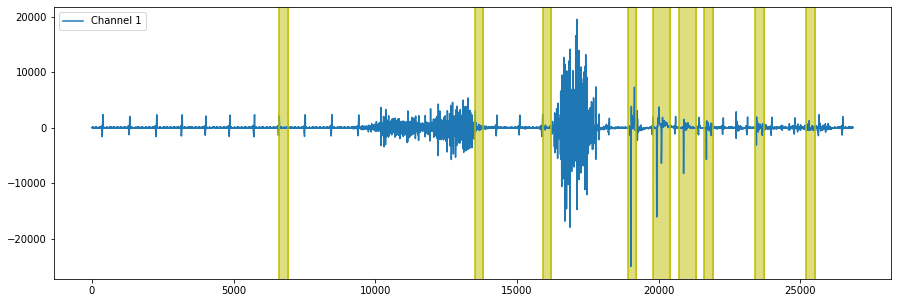

In [51]:
Plot_Zone (data, artifact_zone, span_wind, "y")

In [52]:
#parameters found during optimization
params = {"std":115, "25%":-264, "75%":203, "minmax_ratio_1" : [0.2, 5], "minmax_ratio_2" : [0.656, 1.5]}

## Testing

In [53]:
colors = {"QRS_zone":"orange", "EMG_zone" : "g", "Artifact_zone" : "y", "Noise": "silver"}

### Automatic zone selection

In [ ]:
print ("Accuracy = ", Testing_zone_selection(numb_iter = 10, span = 5000, auto = "Yes", print_all = "Yes"), "%")

### Manual zone selection

In [54]:
print ("Accuracy = ", Testing_zone_selection(numb_iter = 5, span = 5000, auto = "No", print_all = "No"), "%")

Accuracy =  0.0 %


## Prediction

In [61]:
zone = (10000, 13500) 
Predict_Zone (data, zone[0], zone[1], params)

'EMG_zone'

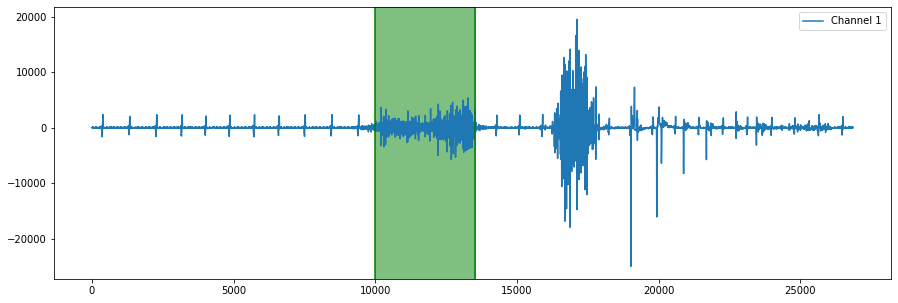

In [62]:
Plot_Zone (data, [zone[0]], zone[1]-zone[0], 'g')